# Dependencies

In [1]:
import pkg_resources
import sys
import subprocess

# List of required packages (use package names as recognized by pip)
required = {
    'geopandas',
    'osmnx',
    'contextily',
    'libpysal',
    'esda',
    'pointpats',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'geodatasets'
}

# Get the set of installed packages
installed = {pkg.key for pkg in pkg_resources.working_set}
# Determine which packages are missing
missing = required - installed

if missing:
    print(f"Installing missing packages: {missing}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
else:
    print("All required packages are already installed.")

All required packages are already installed.


# Python imports

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
from shapely.geometry import Point, Polygon, shape
from shapely.wkt import loads
from libpysal.weights import Queen
from esda import Moran, Moran_Local
from sklearn.cluster import DBSCAN, KMeans
import os
import warnings
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
import contextily as ctx
import libpysal
import esda
import re

# Data collection

In [3]:
# use this to get data from cityofnewyork.us
def load_data(url, filename, usecols=None):
    """
    Downloads a CSV file from a given URL and loads it into a DataFrame.
    """
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        df = pd.read_csv(url, usecols=usecols)
        df.to_csv(filename, index=False)
    else:
        print(f"Loading {filename} from local file...")
        df = pd.read_csv(filename, usecols=usecols)
    return df

## Crime data

In [6]:
crime_data_path = "./data/NYPD_Complaint_Data_Historic.csv"
crime_data_url = "https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD"
crime_cols = ["CMPLNT_FR_DT", "LAW_CAT_CD", "BORO_NM", "ADDR_PCT_CD", "Latitude", "Longitude"]

crime_df = load_data(crime_data_url, crime_data_path, usecols=crime_cols)

# Convert dates to datetime. Parse errors will set value to NaT
crime_df["CMPLNT_FR_DT"] = pd.to_datetime(crime_df["CMPLNT_FR_DT"], format="%m/%d/%Y", errors='coerce')

# Filter for year 2019
crime_df = crime_df[crime_df["CMPLNT_FR_DT"].dt.year == 2019]

# Drop records with missing or invalid coordinates
crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])
crime_df = crime_df[crime_df["Latitude"] != 0]

# convert to geodataframe
crime_gdf = gpd.GeoDataFrame(
    crime_df,
    geometry=gpd.points_from_xy(crime_df["Longitude"], crime_df["Latitude"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

print(f"Total records in 2019: {len(crime_df)}")
crime_gdf.head(3)

Loading ./data/NYPD_Complaint_Data_Historic.csv from local file...
Total records in 2019: 459296


,CMPLNT_FR_DT,ADDR_PCT_CD,LAW_CAT_CD,BORO_NM,Latitude,Longitude,geometry
73179,2019-09-30,106.0,FELONY,QUEENS,40.674100,-73.844419,POINT (-8220323.121 4964389.682)
2356244,2019-11-01,61.0,VIOLATION,BROOKLYN,40.585029,-73.933156,POINT (-8230201.279 4951324.88)
2416574,2019-12-14,47.0,FELONY,BRONX,40.887049,-73.867793,POINT (-8222925.103 4995695.665)


## Population by Neighbourhood tabulation areas (NTA) data

In [4]:
# load data frame with NTA polygons
nta_polys_data_path = "./data/NYC_NTA_Polygons.csv"
nta_polys_data_url = "https://data.cityofnewyork.us/api/views/9nt8-h7nd/rows.csv?accessType=DOWNLOAD"

nta_polys_df = load_data(nta_polys_data_url, nta_polys_data_path)

nta_polys_df.head(3)

# convert to geodataframe
nta_polys_gdf = gpd.GeoDataFrame(
    nta_polys_df,
    geometry=nta_polys_df["the_geom"].apply(loads),
    crs="EPSG:4326"
)

# load data frame with NTA population
nta_pop_data_path = "./data/NYC_NTA.csv"
nta_pop_data_url = "https://data.cityofnewyork.us/api/views/swpk-hqdp/rows.csv?accessType=DOWNLOAD"

nta_pop_df = load_data(nta_pop_data_url, nta_pop_data_path)


Loading ./data/NYC_NTA_Polygons.csv from local file...
Loading ./data/NYC_NTA.csv from local file...


### Cleaning and merging nta data frames

In [34]:
# function to manually convert NTA names to match
def manuel_nta_conversion(row):
    """
    Convert NTA names to match the format in the polygons data.
    """
    def convert_nta(nta):
        if "Airport" in nta:
            return "Airport"
        if "Astoria" in nta:
            return "Old Astoria" if "Old" in nta else "Astoria"
        if "Allerton" in nta or "Pelham Gardens" in nta:
            return "Allerton-Pelham Gardens"
        if "Battery Park City" in nta:
            return "Battery Park City"
        if "Bedford" in nta:
            return "Bedford Park" if "Park" in nta else "Bedford"
        if "Bensonhurst" in nta:
            return "Bensonhurst"
        if "Bushwick" in nta:
            return "Bushwick"
        if "Claremont" in nta:
            return "Claremont"
        if "Harlem" in nta:
            if "East" in nta:
                return "East Harlem North" if "North" in nta else "East Harlem South"
            return "Central Harlem North" if "North" in nta else "Central Harlem South"
        if "Concourse" in nta:
            return "Concourse-Concourse Village"
        if "East New York" in nta:
            return "East New York"
        if "Erasmus" in nta or "East Flatbush" in nta:
            return "East Flatbush-Erasmus"
        
        return nta

    row["NTA Name"] = convert_nta(row["NTA Name"])

    return row

def identify_keywords(s):
    """
    Split into words to find matches
    """
    # Remove special characters and convert to lowercase
    keys = set(re.sub(r"[^a-zA-Z0-9\'\.]", " ", s.lower()).split())
    return keys

def find_candidates(row, df_to_scan, candidate_map, reverse_candidate_map):
    """
    If any word in the poly nta is in the pop nta, it is a candidate.
    """
    candidate_map[row["NTA Name"]] = set()
    keywords = identify_keywords(row["NTA Name"])
    # check if any part is in any of the NTA names in other dataset
    for _, other_row in df_to_scan.iterrows():
        other_keywords = identify_keywords(other_row["NTA Name"])
        # if they have keywords in common
        if len(keywords.intersection(other_keywords)) > 0:
            # add poly as candidate for pop
            candidate_map[row["NTA Name"]].add(other_row["NTA Name"])
            # register for the poly that this pop is pointing to it
            if reverse_candidate_map.get(other_row["NTA Name"]) is None:
                reverse_candidate_map[other_row["NTA Name"]] = set()
            reverse_candidate_map[other_row["NTA Name"]].add(row["NTA Name"])
    return row

def match_candidates(candidate_map):
    def candidate_score(nta, candidate) :
        keys = identify_keywords(nta)
        candidate_keys = identify_keywords(candidate)
        common_keys = keys.intersection(candidate_keys)
        not_in_common_keys = keys.union(candidate_keys) - common_keys
        string_distance = abs(len(nta) - len(candidate))
        return (len(common_keys), -len(not_in_common_keys), -string_distance)

    matches = []
    for nta, candidates in candidate_map.items():
        if not candidates:
            continue
        best_candidate = max(candidates, key=lambda c: candidate_score(nta, c))
        matches.append([nta, best_candidate])

    return matches

def apply_matching(row, matches) :
    """
    Rename pop Match names to match a polygon
    """
    # if multiple map to the same name they are grouped together
    # fx ["Allerton", "Allerton-Pelham Gardens"]
    # row["Match Name"] = "Allerton"
    for match in matches:
        if row["NTA Name"] == match[0]:
            row["Match Name"] = match[1]
            break

    return row

def merge_poly_pop(poly_gdf_arg, pop_df_arg):
    """
    Merge the two dataframes. Goal is to have NTA's with population and polygons.
    """
    poly_gdf = poly_gdf_arg.copy()
    pop_df = pop_df_arg.copy()

    print("Number of polys initially", len(poly_gdf))
    print("Number of pop initially", len(pop_df))

    # manual renaming to catch some more
    poly_gdf = poly_gdf.apply(manuel_nta_conversion, axis=1)
    pop_df = pop_df.apply(manuel_nta_conversion, axis=1)

    # Some NTA's are grouped within the same df. 
    # Like Astoria (Central) and Astoria (East)-Woodside (North). Both are renamed to Astoria to merge them
    # disolve merges the polygons
    poly_gdf = poly_gdf.dissolve(by="NTA Name").reset_index()
    # Two pop nta's merged will sum the population
    pop_df = pop_df.groupby("NTA Name").agg({"Borough": "first", "Population": "sum"}).reset_index()

    print("Number of polys after grouping", len(poly_gdf))
    print("Number of pop after grouping", len(pop_df))
    
    # insert NTA_name and get candidate matches. Can be seen as a digraph where pop nodes point to poly nodes.
    candidate_map = {}
    # reverse is used to see how many in going edges a poly has
    reverse_candidate_map = {}

    # go through each poly and find candidates in the pop df
    # it is a symmetric relation, and we cannot use populations without match, so we try to fit pops onto polys.
    # polys can be kept with a population of 0
    pop_df.apply(find_candidates, axis=1, args=(poly_gdf, candidate_map, reverse_candidate_map))

    # These polys where not candidates for any pops. Keys are only added when something points to poly
    polys_without_candidates = set(poly_gdf["NTA Name"]) - reverse_candidate_map.keys()
    print("Polys without candidates", len(polys_without_candidates))

    # all pops have a key, filter to only get those with a nonempty set
    pops_without_candidates = set(pop_df["NTA Name"]) - set(filter(lambda key: len(candidate_map.get(key)) > 0, candidate_map.keys()))
    print("Pops without candidates", len(pops_without_candidates))
    print(pops_without_candidates)

    # add match name columns. They will be merged based on this column
    poly_gdf["Match Name"] = poly_gdf["NTA Name"]
    pop_df["Match Name"] = pop_df["NTA Name"]

    matches = match_candidates(candidate_map)

    print("Non-equal matches", list(filter(lambda x: x[0] != x[1], matches)))

    print("Number of matches", len(matches))

    # if two NTA's match their Match Name should be the same. We rename pops to match the polygons.
    pop_df = pop_df.apply(apply_matching, axis=1, args=(matches,))

    # join on NTA Name and Borough to create the desired table. Keep NTA names as poly_NTA and pop_NTA
    merged_df = poly_gdf.merge(pop_df, how="left", left_on=["Match Name", "Borough"], right_on=["Match Name", "Borough"], suffixes=("_poly", "_pop"))

    # polys without candidates get population 0
    def set_0_populations(row) :
        if row["NTA Name_poly"] in polys_without_candidates :
            row["Population"] = 0
        return row

    merged_df = merged_df.apply(set_0_populations, axis=1)

    polys_with_pop = merged_df[~merged_df["Population"].isna()]
    print("NTA's with population", len(polys_with_pop))

    print("NTA's with population 0:", len(merged_df[merged_df["Population"] == 0]))

    polys_with_missing_pop = merged_df[merged_df["Population"].isna()]
    print("NTA's with missing population:", len(polys_with_missing_pop))
    print(polys_with_missing_pop[["Borough", "NTA Name_poly"]])

    # unmerged NTA's
    unmerged_pops = pop_df[~pop_df["NTA Name"].isin(merged_df["NTA Name_pop"])]
    print(unmerged_pops[["Borough", "NTA Name", "Match Name"]])

    return merged_df

# only keep 2010 to remove duplicates
nta_pop_simpledf = nta_pop_df[nta_pop_df["Year"] == 2010]

# only keep relevant columns
nta_pop_simpledf = nta_pop_simpledf[["NTA Name", "Borough", "Population"]]
nta_poly_simplegdf = nta_polys_gdf[["NTAName", "BoroName", "the_geom"]].rename(columns={"NTAName": "NTA Name", "BoroName": "Borough"})

# convert to geodataframe
nta_poly_simplegdf = gpd.GeoDataFrame(nta_poly_simplegdf, geometry=nta_poly_simplegdf["the_geom"].apply(loads), crs="EPSG:4326")

# perform merge
merged_df = merge_poly_pop(nta_poly_simplegdf, nta_pop_simpledf)

Number of polys initially 262
Number of pop initially 195
Number of polys after grouping 247
Number of pop after grouping 190
Polys without candidates 5
Pops without candidates 3
{'Manhattanville', 'Steinway', 'Bronxdale'}
Non-equal matches [["Annadale-Huguenot-Prince's Bay-Eltingville", "Annadale-Huguenot-Prince's Bay-Woodrow"], ['Arden Heights', 'Arden Heights-Rossville'], ['Bayside-Bayside Hills', 'Bayside'], ['Breezy Point-Belle Harbor-Rockwy Prk-Broad Chnl', 'Breezy Point-Belle Harbor-Rockaway Park-Broad Channel'], ['Briarwood-Jamaica Hills', 'Jamaica Hills-Briarwood'], ['Brooklyn Heights-Cobble Hill', 'Brooklyn Heights'], ['Carroll Gardens-Columbia Street-Red Hook', 'Carroll Gardens-Cobble Hill-Gowanus-Red Hook'], ['Charleston-Richmond Valley-Tottenville', 'Tottenville-Charleston'], ['Chinatown', 'Chinatown-Two Bridges'], ['Clinton', 'Clinton Hill'], ['Co-Op City', 'Co-op City'], ['Crown Heights North', 'Crown Heights (North)'], ['Crown Heights South', 'Crown Heights (South)'], [

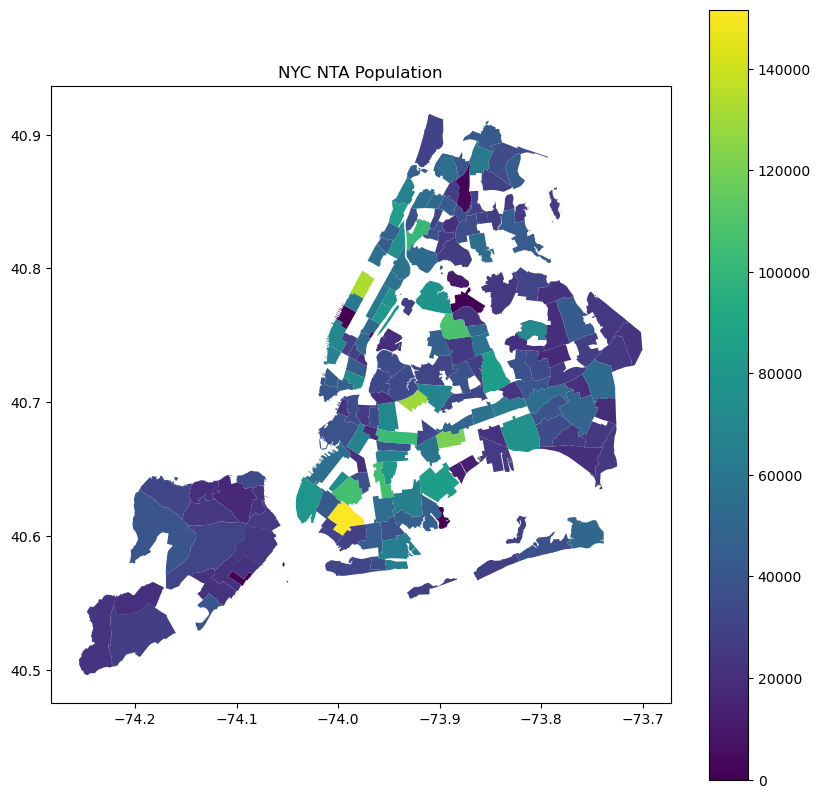

In [35]:
# merged to geodataframe
merged_gdf = gpd.GeoDataFrame(merged_df, geometry=merged_df["the_geom"].apply(loads), crs="EPSG:4326")
# plot merged data
merged_gdf.plot(column="Population", cmap="viridis", legend=True, figsize=(10, 10))
plt.title("NYC NTA Population")
plt.show()

## Amenities data

In [25]:
amenities_data_path = "./data/NYC_Amenities.csv"

# Function to extract coordinates from Point objects or calculate centroid for Polygons
def extract_coordinates(geometry):
    if isinstance(geometry, Point):
        return geometry.x, geometry.y
    elif isinstance(geometry, Polygon):
        centroid = geometry.centroid
        return centroid.x, centroid.y
    return None, None

amenities_df = None
amenities_gdf = None

# Apply the function to the dataset
if os.path.exists(amenities_data_path):
    print("Loading amenities data from local file...")
    amenities_df = pd.read_csv(amenities_data_path, low_memory=False)
    # convert to geodataframe
    amenities_gdf = gpd.GeoDataFrame(
        amenities_df,
        geometry=amenities_df["geometry"].apply(loads),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)
else:
    print("Querying OSM for amenities data...")
    # Define a dictionary of tags for the amenities you're interested in
    tags = {
        "amenity": ["bar", "restaurant"],
        "leisure": "park",
        "railway": "station"
    }

    # Use OSMnx to query OSM for these features in New York City
    amenities_gdf = ox.features.features_from_place("New York City, USA", tags)

    # Extract coordinates or calculate centroid
    amenities_gdf[['Longitude', 'Latitude']] = amenities_gdf['geometry'].apply(lambda x: pd.Series(extract_coordinates(x)))

    # Save the queried data to a CSV file for future use
    amenities_gdf.to_csv(amenities_data_path, index=False)
    amenities_df = amenities_gdf

# Create a new column 'category' to combine 'leisure' and 'amenity'
amenities_gdf['category'] = amenities_gdf['leisure'].combine_first(amenities_gdf['amenity']).combine_first(amenities_gdf['railway'])

# 5) Filter to exactly the four types you want
keep = ["bar", "restaurant", "park", "station"]
amenities_gdf = amenities_gdf[amenities_gdf["category"].isin(keep)]

for amenity in amenities_gdf['category'].unique():
    print(f"Number of {amenity}: {len(amenities_gdf[amenities_gdf['category'] == amenity])}")
    


Loading amenities data from local file...
Number of station: 551
Number of park: 2054
Number of restaurant: 7555
Number of bar: 1343


# Brugbar tekst

## god kilde

Urban crime patterns have been studied from both social and spatial perspectives. Criminology theories such as Broken Windows (Wilson & Kelling, 1982) suggest that the environment plays a role in crime prevalence – for example, disorder in the physical environment might encourage criminal behavior. On the other hand, urbanist Jane Jacobs (1961) argued that active streetscapes with plenty of “eyes on the street” can deter crime, implying that amenities attracting people (cafés, bars, etc.) might enhance safety through informal surveillance.

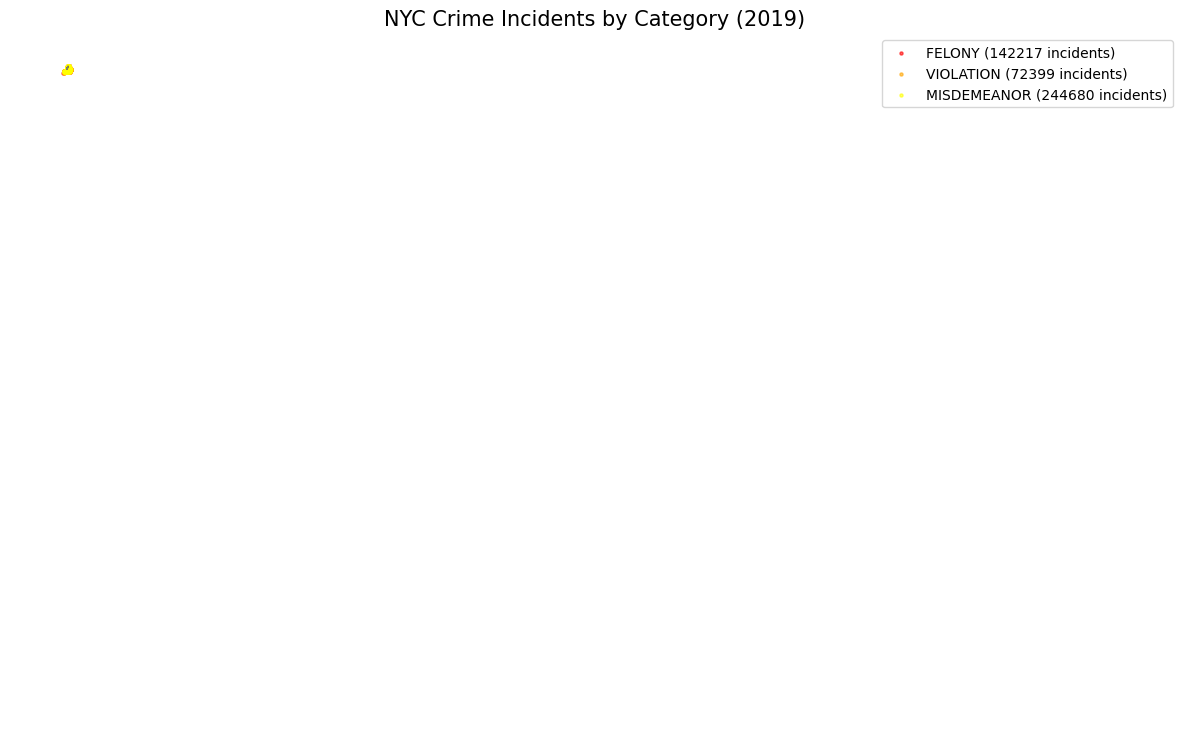


Crime counts by borough:
         BORO_NM   count
0         (null)       7
1          BRONX  100527
2       BROOKLYN  132050
3      MANHATTAN  115783
4         QUEENS   92026
5  STATEN ISLAND   18903


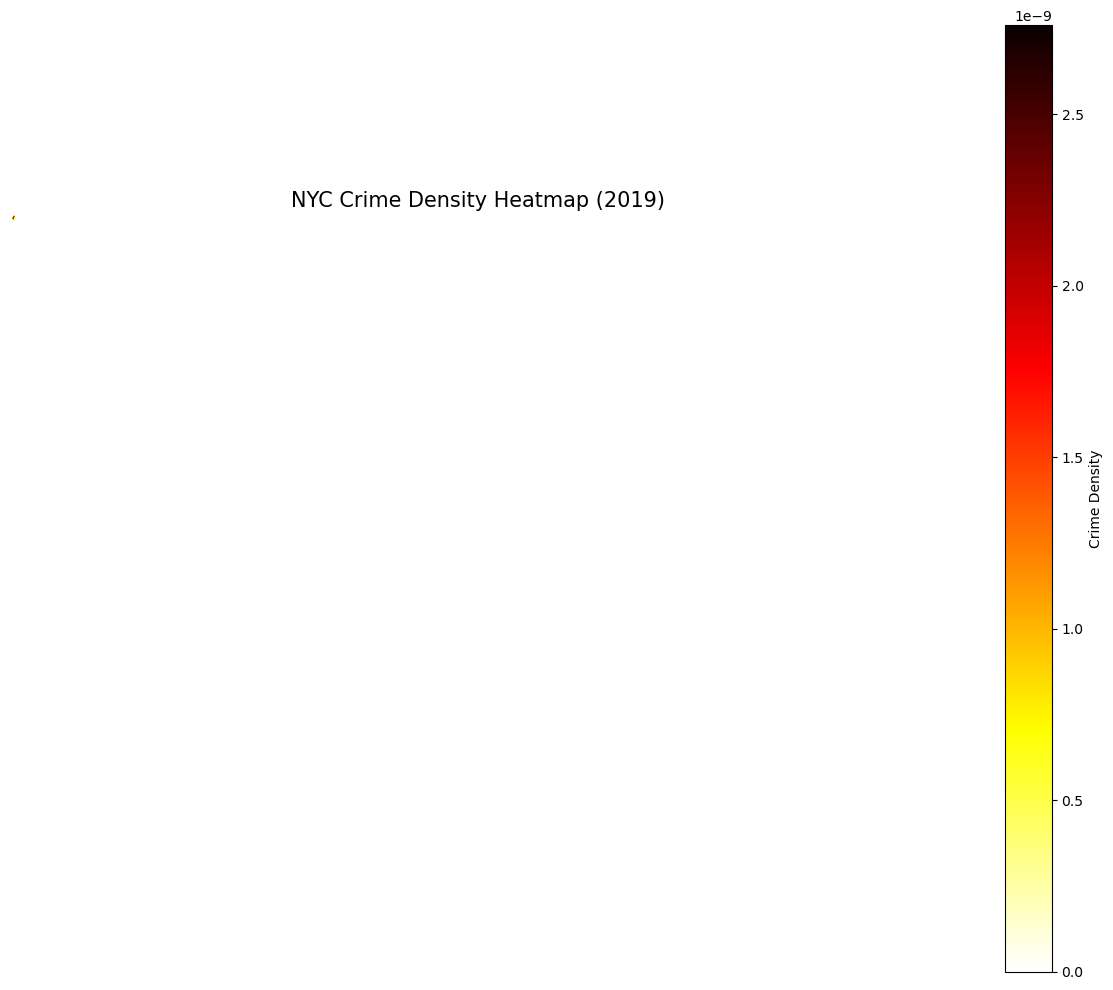

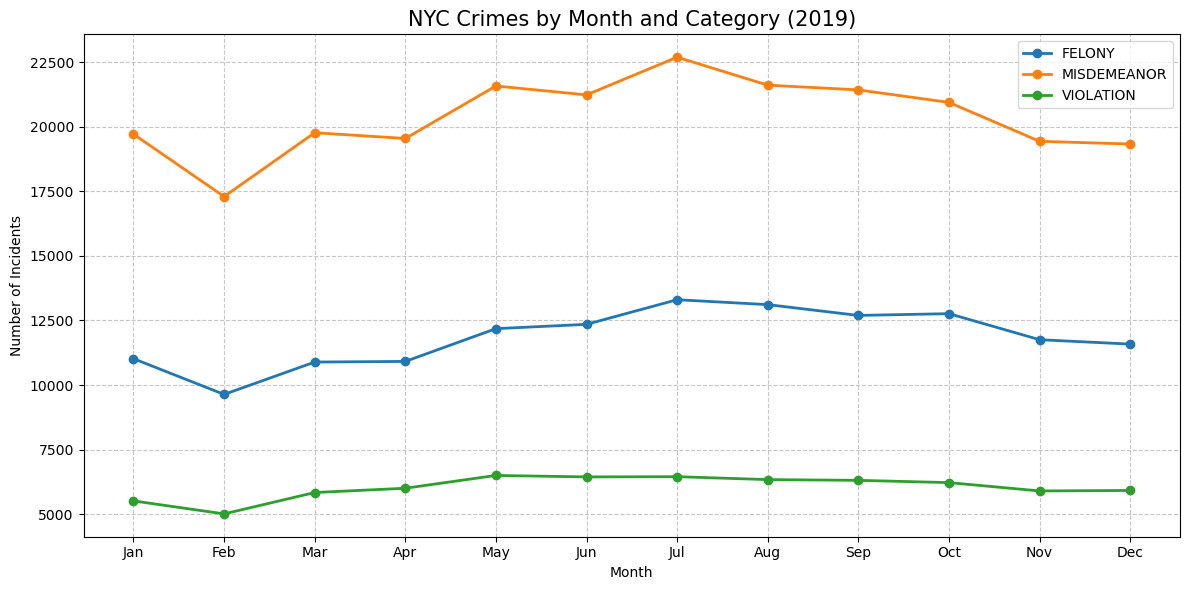

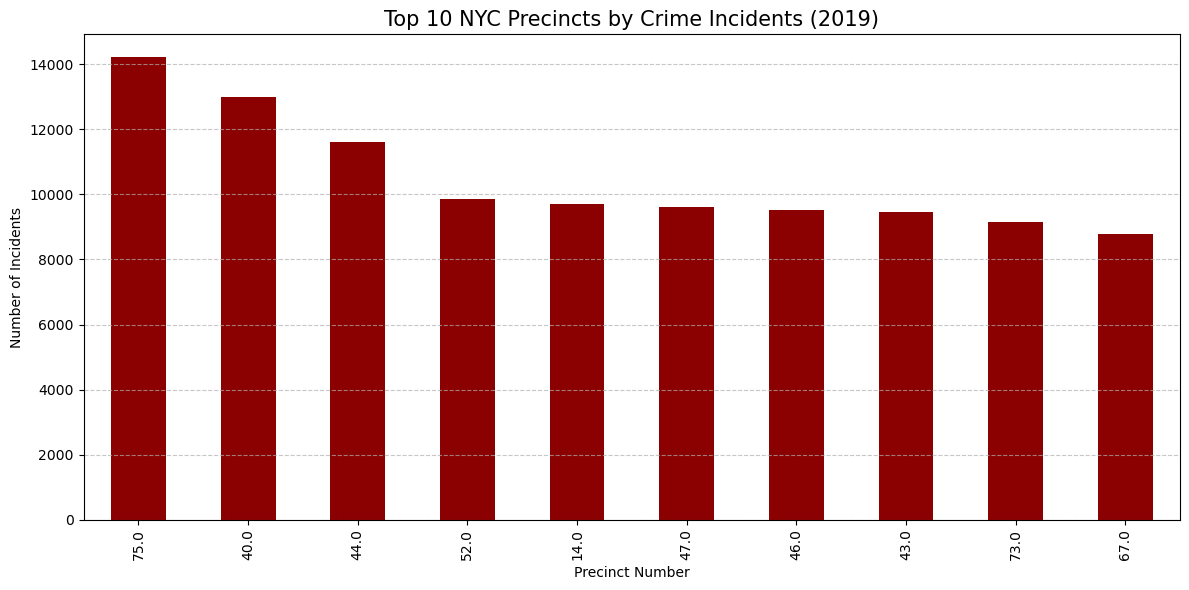

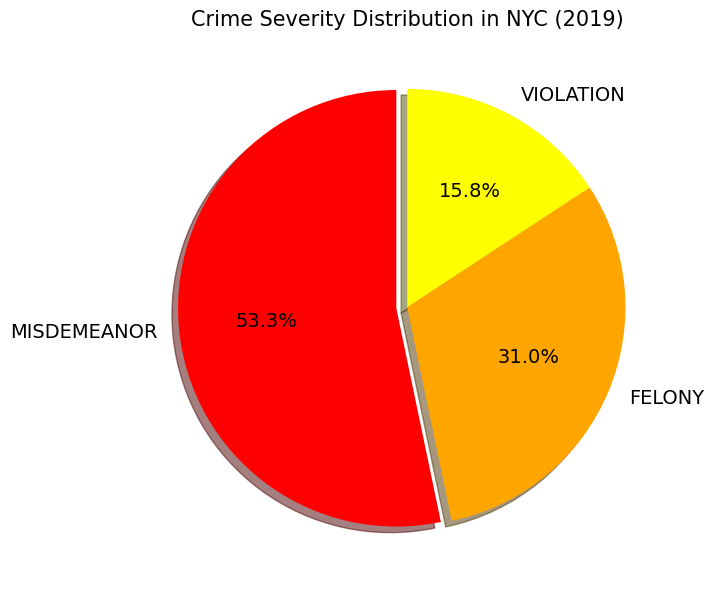


Analysis complete!


In [9]:
warnings.filterwarnings('ignore')

# MAYBE REMOVE nyc_gdf and use NTA's

try:
    nyc_gdf = ox.geocode_to_gdf("New York City, USA")
except:
    # If the above fails, create a simple bounding box for NYC
    nyc_bounds = {
        'north': 40.917577,
        'south': 40.477399,
        'east': -73.700272,
        'west': -74.259090
    }
    nyc_gdf = gpd.GeoDataFrame(
        geometry=[ox.utils.bbox_to_poly(
            north=nyc_bounds['north'],
            south=nyc_bounds['south'],
            east=nyc_bounds['east'],
            west=nyc_bounds['west']
        )],
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

# Extract basic street network for context
try:
    G = ox.graph_from_place("Manhattan, New York City, USA", network_type="drive")
    edges = ox.graph_to_gdfs(G, nodes=False)
    edges = edges.to_crs(epsg=3857)
except:
    # If OSMnx fails, we'll just proceed without the street network
    edges = None
    print("Unable to retrieve street network. Continuing without it.")

# Create a simple visualization of crime data
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the NYC boundary
nyc_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=2, alpha=0.5)

# Plot streets if available
if edges is not None:
    edges.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.5)

# Plot crime data by category
crime_categories = crime_gdf['LAW_CAT_CD'].unique()
colors = ['red', 'orange', 'yellow']
for i, category in enumerate(crime_categories):
    subset = crime_gdf[crime_gdf['LAW_CAT_CD'] == category].sample(min(500, len(crime_gdf[crime_gdf['LAW_CAT_CD'] == category])))
    subset.plot(
        ax=ax,
        color=colors[i % len(colors)],
        alpha=0.6,
        markersize=5,
        label=f"{category} ({len(crime_gdf[crime_gdf['LAW_CAT_CD'] == category])} incidents)"
    )

# Set title and legend
ax.set_title('NYC Crime Incidents by Category (2019)', fontsize=15)
ax.legend(loc='upper right')

# Remove axis labels
ax.set_axis_off()

plt.tight_layout()
plt.show()

# Create a crime heatmap by borough
# First, create a spatial join with boroughs
borough_counts = crime_gdf.groupby('BORO_NM').size().reset_index(name='count')
print("\nCrime counts by borough:")
print(borough_counts)

# Create a heatmap of crime density using KDE
crime_sample = crime_gdf.sample(min(10000, len(crime_gdf)))

# Extract coordinates for KDE
x = crime_sample.geometry.x
y = crime_sample.geometry.y

# Create kernel density estimate
k = gaussian_kde([x, y])
xi, yi = np.mgrid[x.min():x.max():200j, y.min():y.max():200j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Plot the results
plt.figure(figsize=(12, 10))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap='hot_r')
plt.title('NYC Crime Density Heatmap (2019)', fontsize=15)

# Plot NYC boundaries for context
nyc_gdf.boundary.plot(ax=plt.gca(), color='black', linewidth=1)

# Add streets if available
if edges is not None:
    edges.plot(ax=plt.gca(), linewidth=0.2, color='gray', alpha=0.3)

plt.colorbar(label='Crime Density')
plt.axis('off')
plt.tight_layout()
plt.show()

# Crime by time analysis
crime_gdf['Month'] = crime_gdf['CMPLNT_FR_DT'].dt.month
monthly_crimes = crime_gdf.groupby(['Month', 'LAW_CAT_CD']).size().unstack().fillna(0)

# Create a line chart for crimes by month
plt.figure(figsize=(12, 6))
for category in monthly_crimes.columns:
    plt.plot(monthly_crimes.index, monthly_crimes[category], marker='o', linewidth=2, label=category)

plt.title('NYC Crimes by Month and Category (2019)', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Top 10 precincts with highest crime rates
precinct_counts = crime_gdf.groupby('ADDR_PCT_CD').size().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
precinct_counts.plot(kind='bar', color='darkred')
plt.title('Top 10 NYC Precincts by Crime Incidents (2019)', fontsize=15)
plt.xlabel('Precinct Number')
plt.ylabel('Number of Incidents')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Crime severity distribution
severity_counts = crime_gdf['LAW_CAT_CD'].value_counts()

plt.figure(figsize=(10, 6))
severity_counts.plot(kind='pie', autopct='%1.1f%%', colors=['red', 'orange', 'yellow'], 
                    explode=[0.05, 0, 0], shadow=True, startangle=90, textprops={'fontsize': 14})
plt.title('Crime Severity Distribution in NYC (2019)', fontsize=15)
plt.ylabel('')
plt.tight_layout()
plt.show()

print("\nAnalysis complete!")

# Overall Crime Distribution

Extracting 'nybb_16a/nybb.shp' from 'C:\Users\thorc\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip' to 'C:\Users\thorc\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from 'C:\Users\thorc\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip' to 'C:\Users\thorc\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from 'C:\Users\thorc\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip' to 'C:\Users\thorc\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from 'C:\Users\thorc\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip' to 'C:\Users\thorc\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip.unzip'


crime_gdf BORO_NM unique: ['(null)', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']
nybb BoroName unique: ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

Crime counts from spatial join:
 BoroName
Brooklyn         132141
Manhattan        116785
Bronx             99548
Queens            91889
Staten Island     18905
Name: count, dtype: int64


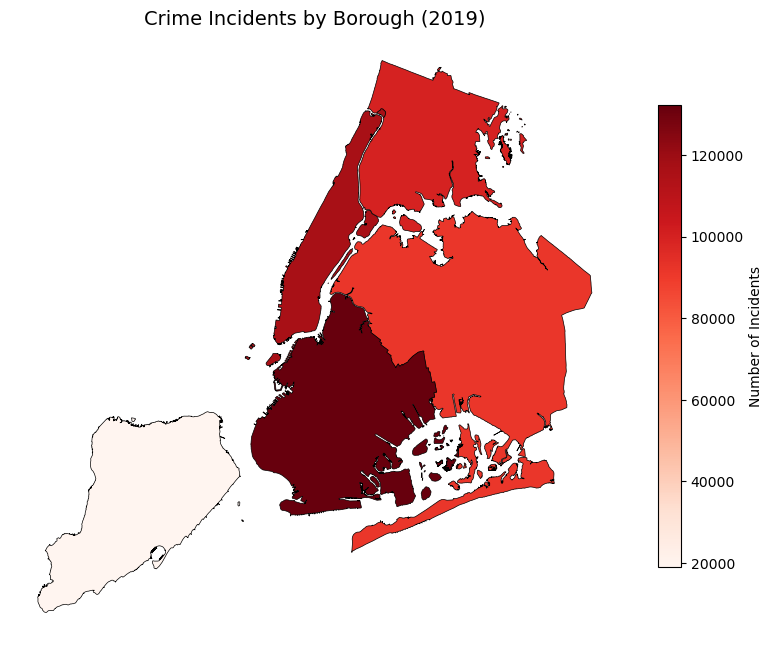

In [10]:
# … (assume crime_gdf is already loaded, filtered & projected) …

# use NTA's instead of boroughs

from geodatasets import get_path

# 1. load boroughs
boroughs_fp = get_path('nybb')
boroughs = gpd.read_file(boroughs_fp).to_crs(crime_gdf.crs)

# 2. inspect name mismatches
print("crime_gdf BORO_NM unique:", sorted(crime_gdf['BORO_NM'].unique()))
print("nybb BoroName unique:",   sorted(boroughs['BoroName'].unique()))

# 3. spatial join to assign each crime point a BoroName
crime_with_boro = gpd.sjoin(
    crime_gdf,
    boroughs[['BoroName','geometry']],
    how='left',
    predicate='within'
)

# 4. count per borough
crime_counts = crime_with_boro['BoroName'].value_counts()
print("\nCrime counts from spatial join:\n", crime_counts)

# 5. merge back into boroughs GeoDataFrame
boroughs['crime_count'] = boroughs['BoroName'].map(crime_counts).fillna(0).astype(int)

# 6. plot choropleth
fig, ax = plt.subplots(figsize=(8, 8))
boroughs.plot(
    column='crime_count',
    ax=ax,
    legend=True,
    cmap='Reds',
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': "Number of Incidents", 'shrink': 0.6}
)
ax.set_title("Crime Incidents by Borough (2019)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


# Crime Hotspots (Clustering Analysis) - DBSCAN


Top 5 clusters and sizes: {0: 430720, 1: 17657, 14: 7085, 13: 728, 8: 588}


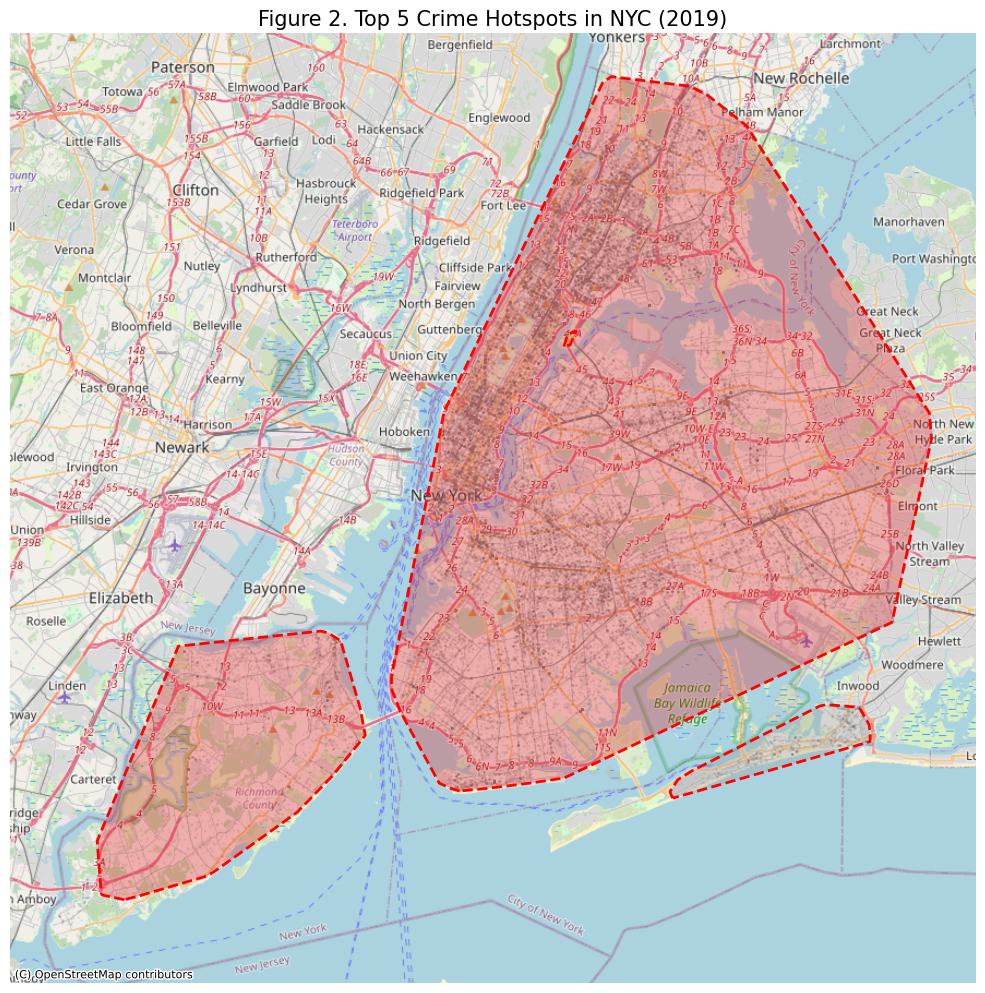

In [11]:
# --- DBSCAN clustering to identify hotspots ---
coords = np.column_stack([crime_gdf.geometry.x, crime_gdf.geometry.y])
db = DBSCAN(eps=500, min_samples=30).fit(coords)
crime_gdf["cluster"] = db.labels_

# Identify top 5 largest clusters (exclude noise)
labels = crime_gdf["cluster"].values
clusters = [lab for lab in set(labels) if lab != -1]
clusters.sort(key=lambda c: (labels == c).sum(), reverse=True)
top5 = clusters[:5]
print("Top 5 clusters and sizes:", {c: int((labels == c).sum()) for c in top5})

# Build convex hulls for these clusters
hotspot_hulls = []
for c in top5:
    pts = crime_gdf[crime_gdf["cluster"] == c]
    hull = pts.unary_union.convex_hull
    hotspot_hulls.append({
        "cluster": c,
        "count": int((labels == c).sum()),
        "geometry": hull
    })
hotspots_gdf = gpd.GeoDataFrame(hotspot_hulls, crs=crime_gdf.crs)

# Ensure Web Mercator for contextily
hotspots_gdf = hotspots_gdf.to_crs(epsg=3857)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 10))
# sample crime points for context
crime_gdf.sample(frac=0.1).plot(ax=ax, color="grey", alpha=0.1, markersize=1)

# plot hull boundaries and fills
hotspots_gdf.boundary.plot(
    ax=ax, color='red', linewidth=2, linestyle='--'
)
hotspots_gdf.plot(
    ax=ax, column='cluster', alpha=0.3, cmap='Set1'
)

# add basemap with fallback
try:
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs=crime_gdf.crs
    )
except Exception as e:
    print("⚠️ Basemap failed:", e)

ax.set_title(
    "Figure 2. Top 5 Crime Hotspots in NYC (2019)", fontsize=15
)
ax.axis("off")
plt.tight_layout()
plt.show()


('WARNING: ', 0, ' is an island (no neighbors)')
Borough               Crime   Neighbor Avg
------------------------------------------
Staten Island         18905            0.0
Queens                91889       116158.0
Brooklyn             132141       104337.0
Manhattan            116785       107859.3
Bronx                 99548       104337.0

Global Moran's I: 0.164
p-value:           0.125


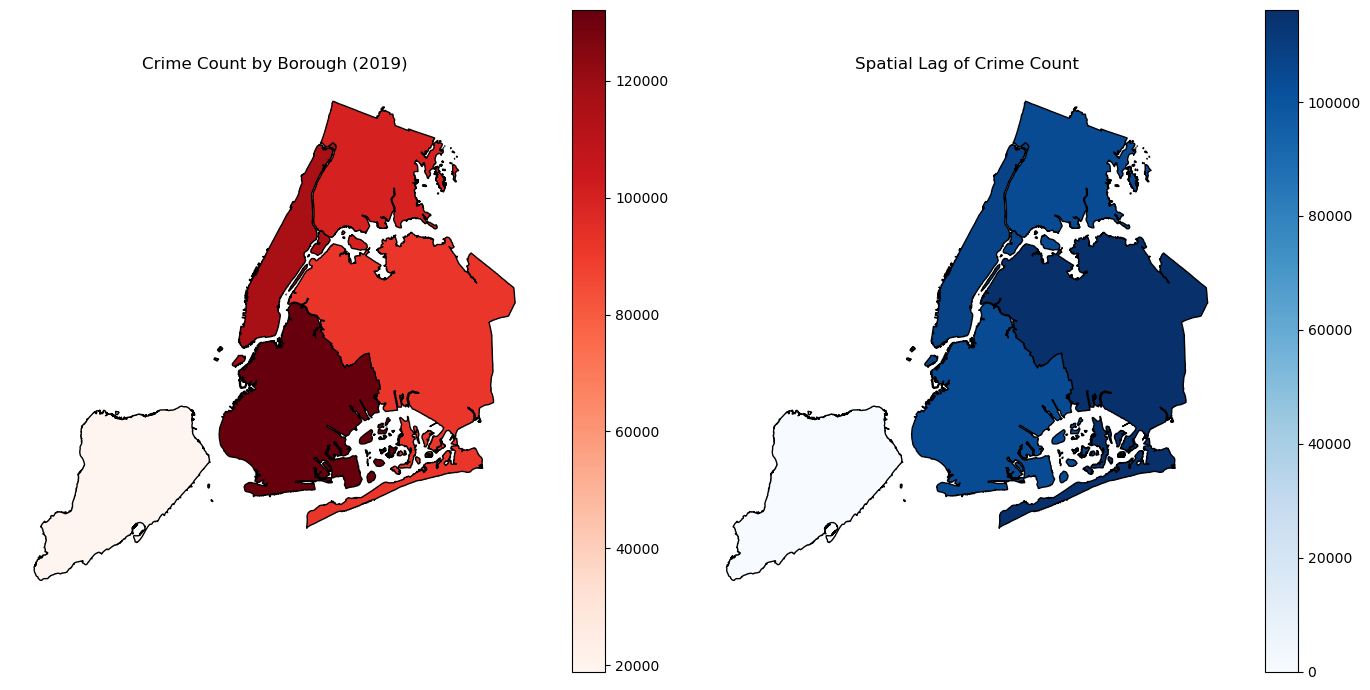

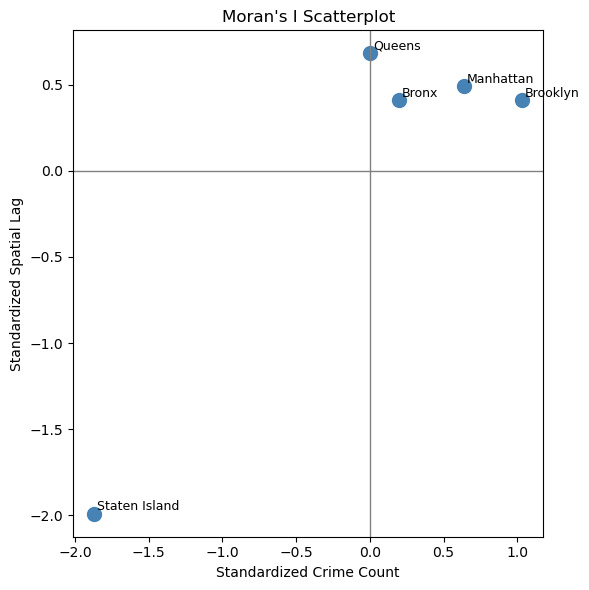

In [12]:
# AGAIN USE NTA's instead of boroughs

# 1) Ensure boroughs has the necessary columns
boroughs['boro_name'] = boroughs.get('boro_name', boroughs['BoroName'])
boroughs['crime_count'] = boroughs['crime_count'].fillna(0).astype(int)

# 2) Build Queen contiguity weights and row-standardize
w = libpysal.weights.Queen.from_dataframe(boroughs)
w.transform = 'R'

# 3) Extract crime counts and compute spatial lag (neighbor average)
counts = boroughs['crime_count'].values
lag = libpysal.weights.lag_spatial(w, counts)

# 4) Print a summary table
print(f"{'Borough':<20} {'Crime':>6} {'Neighbor Avg':>14}")
print("-" * 42)
for name, cnt, nbr_avg in zip(boroughs['boro_name'], counts, lag):
    print(f"{name:<20} {cnt:6d} {nbr_avg:14.1f}")

# 5) Compute Global Moran's I
mi = esda.Moran(counts, w)
print(f"\nGlobal Moran's I: {mi.I:.3f}")
print(f"p-value:           {mi.p_sim:.3f}")

# 6) Add the spatial lag back to the GeoDataFrame
boroughs['spatial_lag'] = lag

# 7) Choropleth maps side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

boroughs.plot(
    column='crime_count',
    cmap='Reds',
    legend=True,
    ax=axes[0],
    edgecolor='black'
)
axes[0].set_title('Crime Count by Borough (2019)')
axes[0].axis('off')

boroughs.plot(
    column='spatial_lag',
    cmap='Blues',
    legend=True,
    ax=axes[1],
    edgecolor='black'
)
axes[1].set_title('Spatial Lag of Crime Count')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# 8) Moran’s I scatterplot
y     = (counts      - counts.mean())      / counts.std()
y_lag = (lag - lag.mean()) / lag.std()

fig, ax = plt.subplots(figsize=(6, 6))
ax.axhline(0, color='gray', linewidth=1)
ax.axvline(0, color='gray', linewidth=1)
ax.scatter(y, y_lag, s=100, color='steelblue')

for i, name in enumerate(boroughs['boro_name']):
    ax.text(y[i] + 0.02, y_lag[i] + 0.02, name, fontsize=9)

ax.set_xlabel('Standardized Crime Count')
ax.set_ylabel('Standardized Spatial Lag')
ax.set_title("Moran's I Scatterplot")
plt.tight_layout()
plt.show()


# Spatial Clustering

In [13]:
# 1) Count restaurants per borough via spatial join
rests = amenities_gdf[amenities_gdf["category"] == "restaurant"]
rests_in_boro = gpd.sjoin(
    rests,
    boroughs[["boro_name", "geometry"]],
    how="inner",
    predicate="within"
)
rest_counts = rests_in_boro.groupby("boro_name").size().to_dict()

# 2) Add restaurant counts to boroughs GeoDataFrame
boroughs["rest_count"] = boroughs["boro_name"].map(rest_counts).fillna(0).astype(int)

# 3) Build feature matrix [crime_count, rest_count] and normalize
features = boroughs[["crime_count", "rest_count"]].values
scaler = StandardScaler()
X = scaler.fit_transform(features)

# 4) Fit KMeans (2 clusters) and attach labels
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
boroughs["cluster"] = kmeans.labels_

# 5) Print results
for _, row in boroughs.iterrows():
    print(
        f"{row.boro_name}: Crime={row.crime_count}, "
        f"Restaurants={row.rest_count}, Cluster={row.cluster}"
    )


Staten Island: Crime=18905, Restaurants=354, Cluster=1
Queens: Crime=91889, Restaurants=1835, Cluster=0
Brooklyn: Crime=132141, Restaurants=1792, Cluster=0
Manhattan: Crime=116785, Restaurants=3342, Cluster=0
Bronx: Crime=99548, Restaurants=230, Cluster=0


=== Average Nearest Neighbor (ANN) Analysis ===
Observed ANN: 3.26 m
Expected ANN (CSR): 27.25 m
R ratio: 0.120

Interpretation:
  • R = 0.120 < 1 → points are clustered (closer than random).
On average, each crime is 3.26 m from its nearest neighbor,
much smaller than the 27.25 m we'd expect if crimes were random.



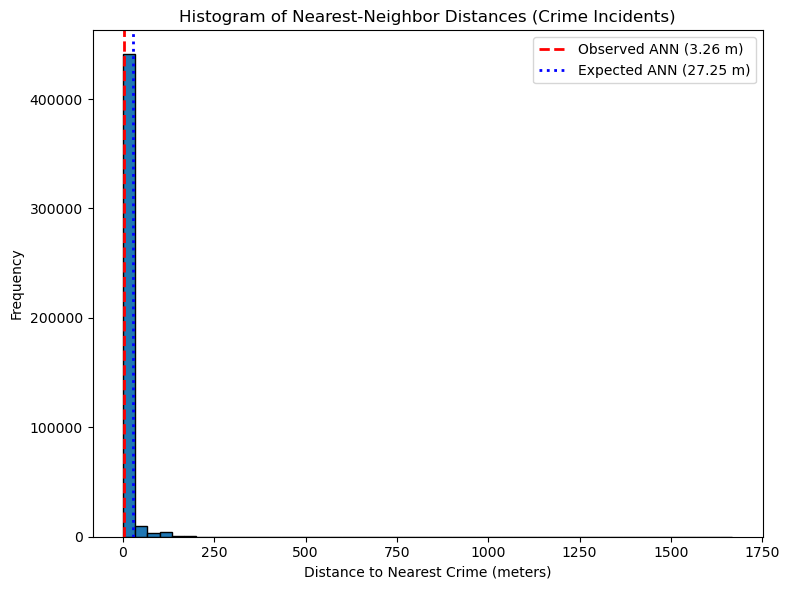

In [14]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# 1. Prepare coordinates of all crime points (in Web Mercator meters)
coords = np.column_stack([crime_gdf.geometry.x, crime_gdf.geometry.y])

# 2. Compute nearest‐neighbor distances (skip self–distance)
nn = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(coords)
distances, _ = nn.kneighbors(coords)
nn_distances = distances[:, 1]  # true nearest neighbor

# 3. Calculate observed Average Nearest Neighbor (ANN)
ann = nn_distances.mean()

# 4. Calculate expected ANN under Complete Spatial Randomness (CSR)
area = boroughs.geometry.unary_union.area     # total study area in m²
n_points = len(crime_gdf)                     # number of crime incidents
expected_ann = 0.5 * np.sqrt(area / n_points)

# 5. Calculate the R ratio
R = ann / expected_ann

# 6. Beginner‐friendly printout
print("=== Average Nearest Neighbor (ANN) Analysis ===")
print(f"Observed ANN: {ann:.2f} m")
print(f"Expected ANN (CSR): {expected_ann:.2f} m")
print(f"R ratio: {R:.3f}\n")
print("Interpretation:")
if R < 1:
    print(f"  • R = {R:.3f} < 1 → points are clustered (closer than random).")
elif R > 1:
    print(f"  • R = {R:.3f} > 1 → points are dispersed (farther than random).")
else:
    print(f"  • R = {R:.3f} ≈ 1 → random spatial pattern.")
print(f"On average, each crime is {ann:.2f} m from its nearest neighbor,")
print(f"much smaller than the {expected_ann:.2f} m we'd expect if crimes were random.\n")

# 7. Visualization: histogram of nearest‐neighbor distances
plt.figure(figsize=(8, 6))
plt.hist(nn_distances, bins=50, edgecolor='black')
plt.axvline(ann, color='red', linestyle='--', linewidth=2, label=f'Observed ANN ({ann:.2f} m)')
plt.axvline(expected_ann, color='blue', linestyle=':', linewidth=2, label=f'Expected ANN ({expected_ann:.2f} m)')
plt.title("Histogram of Nearest‐Neighbor Distances (Crime Incidents)")
plt.xlabel("Distance to Nearest Crime (meters)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
